#**Выявление ключевых слов в англоязычных текстах по теме "Education"**

*Education Today*  is a business magazine targeting the entire education sector from primary to adult education.

https://www.education-today.co.uk/



---


*Keyword Extraction with BERT* - a minimal method for extracting keywords and keyphrases
 
https://towardsdatascience.com/keyword-extraction-with-bert-724efca412ea

## Установка библиотек

In [ ]:
# устанавиливаем библиотеки и модули 
! pip3 install requests # для парсинга сайтов
! pip3 install beautifulsoup4 # для удобной работы с html-тегами
! pip3 install sentence-transformers # для Keyword Extraction


     |████████████████████████████████| 78 kB 3.2 MB/s 
     |████████████████████████████████| 2.9 MB 27.1 MB/s 
     |████████████████████████████████| 3.3 MB 68.1 MB/s 
     |████████████████████████████████| 1.2 MB 44.8 MB/s 
     |████████████████████████████████| 56 kB 5.1 MB/s 
     |████████████████████████████████| 596 kB 56.5 MB/s 
     |████████████████████████████████| 895 kB 45.2 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=121000 sha256=f2adc0d940293120cea4584097dff9866472428cd9690ae48e6cf0b6dfccf426
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
# импортируем необходимые модули для парсинга сайта
import requests
from bs4 import BeautifulSoup

# импортируем необходимые модули для формирования датафрейма
import pandas as pd
from google.colab import files

# импортируем необходимые модули для предпроцессинга и лемматизации текстов
import nltk
import string
import re
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords.words("english")
stop_words = stopwords.words('english')
from nltk.tokenize import sent_tokenize,word_tokenize
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

# импортируем необходимые модули для визуализации
import matplotlib.pyplot as plt
from matplotlib import cm
from collections import Counter
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# импортируем необходимые модули для извлечения ключевых слов (Keyword Extraction) с помощью KeyBERT
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens') # можно также использовать модель xlm-r-distilroberta-base-paraphase-v1 (не сработало)
from sklearn.feature_extraction.text import CountVectorizer


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/450 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Парсинг сайта

In [ ]:
# функция для обработки URL-адресов страниц
def get_soup(url, **kwargs):
    response = requests.get(url, **kwargs)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, features='html.parser')
    else:
        soup = None
    return soup

In [ ]:
# функция для сбора ссылок на страницы со статьями на сайте журнала "Education Today"
# принимает на вход количество страниц со статьями, а на выходе возвращает список ссылок на статьи с этих страниц

def crawl_links_en(pages_count):
    urls = []
    fmt = 'https://www.education-today.co.uk/category/news/page/{page}/' # шаблон URL-адреса страницы со статьями

    for page_n in range(1, 1 + pages_count):
        print('page: {}'.format(page_n))

        page_url = fmt.format(page=page_n)
        soup = get_soup(page_url)
        if soup is None:
            break

        for tag in soup.select(' .more-link'): # CSS-селектор cсылки на статью
            href = tag.attrs['href']
            url = '{}'.format(href)
            urls.append(url)

    return urls

In [ ]:
# функция для парсинга текста статей журнала "Education Today"
# принимает список URL-адресов, парсит необходимую информацию по каждой статье и добавляет её в общий массив data, который и возвращает

def parse_links_en(urls):
    data = []

    for url in urls:
        soup = get_soup(url)
        if soup is None:
            break

        title = soup.select_one('title').text.strip() # сохраняем заголовок статьи 
        article_url = url # сохраняем ссылку на статью
        article_text = ' '.join([soup.find('div', {'class': 'entry'}).text.strip()]) # сохраняем текст статьи как строку
        article_category = []
        for tag in soup.find_all('a', rel="category tag"): 
            article_category.append(tag.text.strip()) # сохраняем список тематических категорий статьи
        date = soup.find('p', {'class': 'post-meta'}).find('span', {'class': 'tie-date'}).text.strip() # сохраняем дату публикации


        item = {
            'Title': title,
            'Category': article_category,
            'Date': date,
            'Link': url,
            'Text': article_text,
        }
        data.append(item)

# чтобы сохранить результат используем метод pd.DataFrame(), где аргументом подадим словарь из полученных данных
    result = pd.DataFrame(data)
    
    return result    

In [ ]:
# Собираем информацию с сайта газеты "Education Today Magazine". 

articles_dataset_en_13Aug2021 = parse_links_en(crawl_links_en(54)) # собираем ссылки, а потом информацию о статьях (по данным на 13.08.2021 на сайте всего 54 страницы с новостями)
articles_dataset_en_13Aug2021.to_csv('54articles_dataset_en_13Aug2021.csv', index=False) #сохраняем полученные данные в формат csv
articles_dataset_en_13Aug2021

page: 1
page: 2
page: 3
page: 4
page: 5
page: 6
page: 7
page: 8
page: 9
page: 10
page: 11
page: 12
page: 13
page: 14
page: 15
page: 16
page: 17
page: 18
page: 19
page: 20
page: 21
page: 22
page: 23
page: 24
page: 25
page: 26
page: 27
page: 28
page: 29
page: 30
page: 31
page: 32
page: 33
page: 34
page: 35
page: 36
page: 37
page: 38
page: 39
page: 40
page: 41
page: 42
page: 43
page: 44
page: 45
page: 46
page: 47
page: 48
page: 49
page: 50
page: 51
page: 52
page: 53
page: 54


Title  ...                                               Text
0    How could AI affect your organisation? – Educa...  ...  Artificial intelligence is rapidly revolutioni...
1    Keep pupils active this summer with Public Hea...  ...  Evidence suggests that regular physical activi...
2    Distinguished schools recognised for maths att...  ...  Fourteen UK schools and almost forty in countr...
3    Warwickshire CCC and Sandwell College form par...  ...  Warwickshire CCC and Sandwell College have ann...
4    LEO Academy Trust pupils get creative with Big...  ...  Sutton-based LEO Academy Trust has launched it...
..                                                 ...  ...                                                ...
529  School finalists revealed for the Apps for Goo...  ...  Apps for Good has today announced the finalist...
530  First World War project for children launched ...  ...  ‘The war to end all wars’ is the subject of a ...
531  Inaugural Beanstalk Ball raises over £170K for...  ...  Over 200 people who could read and write, incl...
532  Vocab Express to partner with Language Show Li...  ...  Online vocabulary learning application, Vocab ...
533  Wallace and Gromit need your help! – Education...  ...  Wallace & Gromit’s Children’s Charity is a nat...

[534 rows x 5 columns]

## Предобработка

In [ ]:
# Предобработка текстов из англоязычного датасета
# загружаем полученный файл 
files.upload()

Saving 54articles_dataset_en_13Aug2021.csv to 54articles_dataset_en_13Aug2021.csv


{'54articles_dataset_en_13Aug2021.csv': b'Title,Category,Date,Link,Text\nHow could AI affect your organisation? \xe2\x80\x93 Education Today,[\'News\'],1 week ago,https://www.education-today.co.uk/how-could-ai-affect-your-organisation/,"Artificial intelligence is rapidly revolutionising the way we live and work. In higher education, AI is already having an impact on how we teach students, how we assess them and even how we support them.\nBut are we ready for the implications of artificial intelligence?\nAI is already being put to innovative use in higher education. AI is helping with recruitment and marketing, the admissions and enrolment process, guiding students through their courses and creating personalised learning plans.\nBut as we become more and more reliant on AI, we need to ask ourselves three important questions.\n1) Are we missing out on human inputs?\nOne of the main arguments for AI is that decisions made by advanced technologies are more intelligent, are based on a wider

In [ ]:
# откроем получившийся файл csv и сохраним все тексты статей из таблицы в привычный питонский список

en_df = pd.read_csv('54articles_dataset_en_13Aug2021.csv', encoding="utf-8") 
list_en_texts = list(en_df["Text"].values) 
 
print(type(list_en_texts)) # проверяем тип переменной
list_en_texts

<class 'list'>


['Artificial intelligence is rapidly revolutionising the way we live and work. In higher education, AI is already having an impact on how we teach students, how we assess them and even how we support them.\nBut are we ready for the implications of artificial intelligence?\nAI is already being put to innovative use in higher education. AI is helping with recruitment and marketing, the admissions and enrolment process, guiding students through their courses and creating personalised learning plans.\nBut as we become more and more reliant on AI, we need to ask ourselves three important questions.\n1) Are we missing out on human inputs?\nOne of the main arguments for AI is that decisions made by advanced technologies are more intelligent, are based on a wider array of data and are more consistent. But in education, we also need to consider how much we value human inputs.\nCan AI understand a student as well as a professor or a teacher? Can AI factor in the multiple variables that are best 

In [ ]:
# функция для предобработки и лемматизации текста

def preprocess_en_lemmatize(text):

  lower_text = text.lower() # приводим все слова к нижнему регистру
  no_links_text = re.sub(r'https?:\/\/.*[\r\n]*', '', lower_text)  # убираем все ссылки, начинающиеся с https
  no_links_text2 = re.sub(r'www\.\S+\.\S+[\r\n]*', '', no_links_text)  # убираем все ссылки, начинающиеся с www
  no_links_text3 = re.sub(r'\(?\S+\.\S+\.?\S+?[\r\n]*', '', no_links_text2)  # убираем все ссылки без www
  no_email_text = re.sub(r'\S+@\S+', '', no_links_text3)  # убираем все адреса email
  no_extra_punct = re.sub('[0-9‘’–‑“”£•®]', '', no_email_text)  # убираем нетипичные знаки пунктуации и цифры (при необходимости можно увеличить список вручную)
  text_without_punct = no_extra_punct.translate(str.maketrans('', '', string.punctuation)) # убираем пунктуацию из текста
  text_tokens = word_tokenize(text_without_punct, language="english") # токенизируем текст превращая его в список 
  
  #filtered_tokens = [word for word in text_tokens if word not in stop_words] # доп.строка чтобы убрать стоп слова
  # при необходимости ее использования изменить  text_tokens в следующей строке на filtered_tokens
  
  text_lemmatized = ' '.join([lemmatizer.lemmatize(w) for w in text_tokens])  # лемматизируем токенизированный список и возвращаем его как строку 

  return text_lemmatized

In [ ]:
# функция для предобработки списка текстов и сохранения в новый список

def get_en_list_preprocessed (texts):

  data = []
  
  for text in texts:
    text_preprocessed = preprocess_en_lemmatize(text)

    data.append(text_preprocessed)

  return data

In [ ]:
# предобрабатываем тексты статей из таблицы и сохраняем их в список

list_en_texts_preprocessed = get_en_list_preprocessed(list_en_texts)
list_en_texts_preprocessed 

['artificial intelligence is rapidly revolutionising the way we live and work in higher education ai is already having an impact on how we teach student how we ass them and even how we support them but are we ready for the implication of artificial intelligence ai is already being put to innovative use in higher education ai is helping with recruitment and marketing the admission and enrolment process guiding student through their course and creating personalised learning plan but a we become more and more reliant on ai we need to ask ourselves three important question are we missing out on human input one of the main argument for ai is that decision made by advanced technology are more intelligent are based on a wider array of data and are more consistent but in education we also need to consider how much we value human input can ai understand a student a well a a professor or a teacher can ai factor in the multiple variable that are best understood by an expert tutor are we oversimpl

In [ ]:
# Выявление ключевых слов с помощью метода KeyBERT
# функция для векторизации текста и обучения модели для трансформации

def keyword_model (doc):

  n_gram_range = (1, 1) # количество ключевых слов/словосочетаний (можно менять количество)
  stop_words = "english"

  count = CountVectorizer(ngram_range=n_gram_range, stop_words=stop_words).fit([doc]) # извлекаем ключевые слова/фразы-кандидаты
  candidates = count.get_feature_names() # получаем список строк с кандидатами

  # применение предобученной модели для трансформации 

  doc_embedding = model.encode([doc])
  candidate_embeddings = model.encode(candidates)

  # вычисление косинусной близости 
  top_n = 10 # количество наиболее важных ключевых слов
  distances = cosine_similarity(doc_embedding, candidate_embeddings)
  keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]]
  
  return keywords

In [ ]:
# функция получения ключевых слов списка текстов

def keyword_list(texts):
  
  data = []
  
  for text in texts:
    keywords = keyword_model(text)

    data.append(keywords)

  return data

In [ ]:
# применяем функцию для получения списка ключевых слов текстов статей газеты "Education Today Magazine" 

keyword_list_en = keyword_list(list_en_texts_preprocessed)
keyword_list_en

[['innovative',
  'student',
  'intelligence',
  'education',
  'teacher',
  'learning',
  'professor',
  'teaching',
  'party',
  'revolutionising'],
 ['swim',
  'daily',
  'fun',
  'curriculumlinked',
  'favourite',
  'july',
  'worldclass',
  'summer',
  'wellbeing',
  'disney'],
 ['academic',
  'tutor',
  'mexico',
  'teacher',
  'math',
  'awardwinning',
  'ceo',
  'mathematician',
  'headteacher',
  'mathswhizz'],
 ['cricketing',
  'charity',
  'friday',
  'training',
  'cricketer',
  'stadium',
  'coach',
  'august',
  'cricketplaying',
  'coaching'],
 ['performance',
  'enriching',
  'naturethemed',
  'theatre',
  'annual',
  'competition',
  'dance',
  'dancing',
  'celebration',
  'dancebased'],
 ['friend',
  'worsen',
  'family',
  'harming',
  'worry',
  'battle',
  'teacher',
  'anxiety',
  'health',
  'sick'],
 ['university',
  'fridge',
  'concert',
  'gym',
  'germany',
  'leipzig',
  'partying',
  'basecamp',
  'denmark',
  'partygoer'],
 ['app',
  'downloaded',
  'lea

In [ ]:
upgraded_en_dataframe.to_csv('en_articles_keywords_dataset_13Aug2021.csv', index=False) #сохраняем полученные данные в формат csv


In [ ]:
upgraded_en_dataframe.set_value('0', 'Date', "August 5, 2021')

SyntaxError: ignored

In [ ]:
# Обновление датафрейма
# добавляем полученные результаты в датафрейм и сохраняем его под новым именем

upgraded_en_dataframe = en_df.assign(Text_preprocessed=list_en_texts_preprocessed,
                                     Keywords=keyword_list_en)
upgraded_en_dataframe.to_csv('en_articles_keywords_dataset_13Aug2021.csv', index=False) #сохраняем полученные данные в формат csv

display(upgraded_en_dataframe)

Title  ...                                           Keywords
0    How could AI affect your organisation? – Educa...  ...  [innovative, student, intelligence, education,...
1    Keep pupils active this summer with Public Hea...  ...  [swim, daily, fun, curriculumlinked, favourite...
2    Distinguished schools recognised for maths att...  ...  [academic, tutor, mexico, teacher, math, award...
3    Warwickshire CCC and Sandwell College form par...  ...  [cricketing, charity, friday, training, cricke...
4    LEO Academy Trust pupils get creative with Big...  ...  [performance, enriching, naturethemed, theatre...
..                                                 ...  ...                                                ...
529  School finalists revealed for the Apps for Goo...  ...  [barclaycard, ninja, samsung, innovation, ceo,...
530  First World War project for children launched ...  ...  [website, online, centenary, newsreel, downloa...
531  Inaugural Beanstalk Ball raises over £170K for...  ...  [champagne, generosity, auctioneer, ceo, grand...
532  Vocab Express to partner with Language Show Li...  ...  [ipad, website, university, saturday, online, ...
533  Wallace and Gromit need your help! – Education...  ...  [therapy, hospital, competition, goal, favouri...

[534 rows x 7 columns]

In [ ]:
# Визуализация полученных данных
# загружаем финальный датафрейм для визуализации
files.upload()

In [ ]:
# если загружаем данные из датафрейма, то получаем список списков, преобразуем его в простой список

en_df_kw = pd.read_csv('en_articles_keywords_dataset_13Aug2021.csv', encoding="utf-8") 
kw = en_df_kw["Keywords"].values

keyword_list = re.sub('[\[\]\,\']',' ', (''.join(kw))).split() # превращаем список списков в строку, удаляем знаки пунктуации и превращаем обратно в список
keyword_list

In [ ]:
# если работаем с полученной переменной из прошлого шага
# функция для объединения всех ключевых слов в один список

def listmerge(lstlst):
    data=[]
    for lst in lstlst:
        for el in lst:
            data.append(el)
    return data

# применяем функцию к списку списков keywords

my_list = listmerge(keyword_list_en)
my_list

['innovative',
 'student',
 'intelligence',
 'education',
 'teacher',
 'learning',
 'professor',
 'teaching',
 'party',
 'revolutionising',
 'swim',
 'daily',
 'fun',
 'curriculumlinked',
 'favourite',
 'july',
 'worldclass',
 'summer',
 'wellbeing',
 'disney',
 'academic',
 'tutor',
 'mexico',
 'teacher',
 'math',
 'awardwinning',
 'ceo',
 'mathematician',
 'headteacher',
 'mathswhizz',
 'cricketing',
 'charity',
 'friday',
 'training',
 'cricketer',
 'stadium',
 'coach',
 'august',
 'cricketplaying',
 'coaching',
 'performance',
 'enriching',
 'naturethemed',
 'theatre',
 'annual',
 'competition',
 'dance',
 'dancing',
 'celebration',
 'dancebased',
 'friend',
 'worsen',
 'family',
 'harming',
 'worry',
 'battle',
 'teacher',
 'anxiety',
 'health',
 'sick',
 'university',
 'fridge',
 'concert',
 'gym',
 'germany',
 'leipzig',
 'partying',
 'basecamp',
 'denmark',
 'partygoer',
 'app',
 'downloaded',
 'learning',
 'teaching',
 'website',
 'teacher',
 'classroom',
 'online',
 'apps',
 

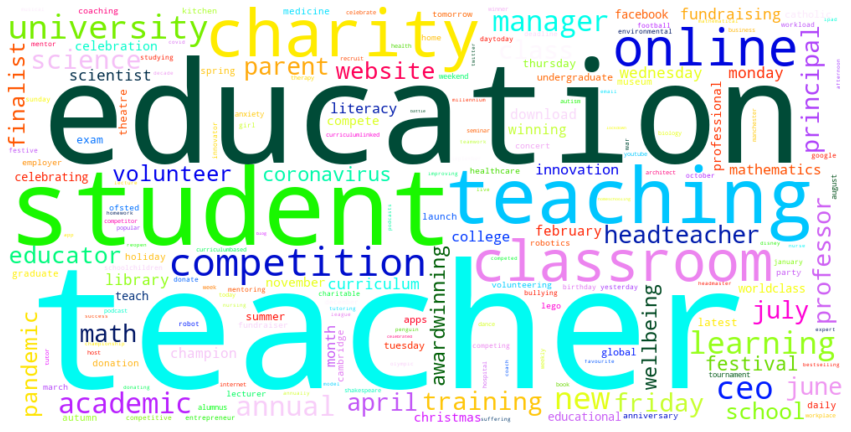

In [ ]:
# Создаем стандартный WordCloud для визуализации данных

word_could_dict=Counter(my_list) # преобразует список слов в словарь с количеством их употребления

wordcloud = WordCloud(width = 1000, height = 500, background_color="white", colormap='gist_ncar').generate_from_frequencies(word_could_dict)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

wordcloud.to_file("education_keywordsgist_ncar.png") # сохраняем в файл

In [ ]:
# загружаем файл картинки для того, чтобы сделать облако в форме изображения (формат .png) 
# если цвет фона не белый (225), то применить функцию замены цвета из раздела Extra
files.upload()

Saving studhat.png to studhat.png


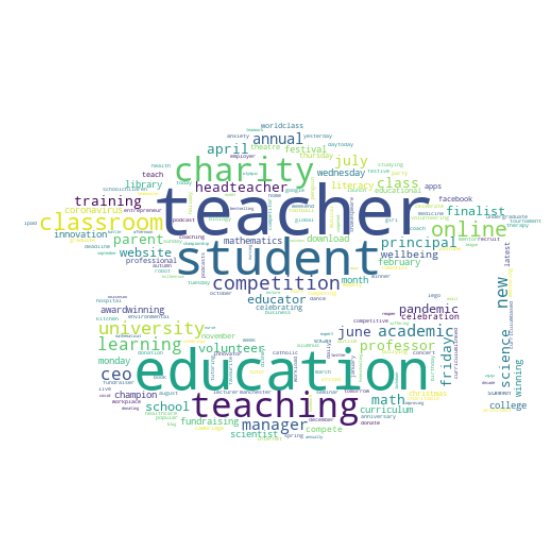

In [ ]:
# Создаем WordCloud в форме картинки
cloud_mask = np.array(Image.open("studhat.png")) # открываем загруженную картинку

wordcloud_masked = WordCloud(background_color="white", mask=cloud_mask, colormap='viridis').generate_from_frequencies(word_could_dict)

plt.figure(figsize=[20,10])
plt.imshow(wordcloud_masked, interpolation='bilinear')
plt.axis("off")
plt.show()

wordcloud_masked.to_file("education_keywords_maskedviridis.png") # сохраняем в файл

In [ ]:
#Cделать статистику по корпусу
# Sample corpus.

corpus = ''.join(list_en_texts)
print(corpus)

Artificial intelligence is rapidly revolutionising the way we live and work. In higher education, AI is already having an impact on how we teach students, how we assess them and even how we support them.
But are we ready for the implications of artificial intelligence?
AI is already being put to innovative use in higher education. AI is helping with recruitment and marketing, the admissions and enrolment process, guiding students through their courses and creating personalised learning plans.
But as we become more and more reliant on AI, we need to ask ourselves three important questions.
1) Are we missing out on human inputs?
One of the main arguments for AI is that decisions made by advanced technologies are more intelligent, are based on a wider array of data and are more consistent. But in education, we also need to consider how much we value human inputs.
Can AI understand a student as well as a professor or a teacher? Can AI factor in the multiple variables that are best understo

In [ ]:
# определяем статистику по корпусу статей

sents = nltk.sent_tokenize(corpus)
print("The number of sentences:", len(sents))
words = nltk.word_tokenize(corpus)
print("The number of tokens:", len(words))
average_tokens = round(len(words)/len(sents))
print("The average number of tokens per sentence:",average_tokens)
unique_tokens = set(words)
print("The number of unique tokens:", len(unique_tokens))

final_tokens = []
for each in words:
 if each not in stop_words_ru:
    final_tokens.append(each)
print("The number of total tokens after removing stopwords:", len((final_tokens)))

number_of_keywords = len(keyword_list)
print("The number of elements in the keywords list: ", number_of_keywords)
unique_keywords = Counter(word_could_dict).most_common()
number_of_unique_kw = len(unique_keywords) 
print("The number of unique keywords:", (number_of_unique_kw))


In [ ]:
Counter(word_could_dict).most_common(50)

[('teacher', 197),
 ('education', 122),
 ('student', 112),
 ('teaching', 103),
 ('charity', 100),
 ('classroom', 92),
 ('online', 76),
 ('competition', 67),
 ('university', 63),
 ('ceo', 57),
 ('learning', 54),
 ('new', 54),
 ('academic', 44),
 ('manager', 44),
 ('annual', 41),
 ('science', 37),
 ('friday', 35),
 ('class', 35),
 ('training', 34),
 ('math', 32),
 ('june', 32),
 ('parent', 32),
 ('headteacher', 31),
 ('july', 30),
 ('april', 30),
 ('principal', 29),
 ('professor', 28),
 ('website', 27),
 ('educator', 27),
 ('school', 25),
 ('pandemic', 24),
 ('finalist', 24),
 ('volunteer', 24),
 ('wellbeing', 21),
 ('awardwinning', 21),
 ('coronavirus', 21),
 ('festival', 19),
 ('fundraising', 19),
 ('library', 19),
 ('curriculum', 19),
 ('scientist', 18),
 ('monday', 18),
 ('wednesday', 17),
 ('college', 16),
 ('mathematics', 16),
 ('literacy', 16),
 ('month', 16),
 ('innovation', 16),
 ('download', 15),
 ('february', 15)]

In [ ]:
# Сохраняем данные об уникальных ключевых словах в файл

kwl = list(unique_keywords) # переменная является tuple, сохраняем ее в list
unique_keywords_counter = ' '.join(map(str,kwl)) # преобразуем в строку
with open('unique_keywords_counter.txt', 'w') as f:
  f.write(unique_keywords_counter)

[('teacher', 197),
 ('education', 122),
 ('student', 112),
 ('teaching', 103),
 ('charity', 100),
 ('classroom', 92),
 ('online', 76),
 ('competition', 67),
 ('university', 63),
 ('ceo', 57),
 ('learning', 54),
 ('new', 54),
 ('academic', 44),
 ('manager', 44),
 ('annual', 41),
 ('science', 37),
 ('friday', 35),
 ('class', 35),
 ('training', 34),
 ('math', 32),
 ('june', 32),
 ('parent', 32),
 ('headteacher', 31),
 ('july', 30),
 ('april', 30),
 ('principal', 29),
 ('professor', 28),
 ('website', 27),
 ('educator', 27),
 ('school', 25),
 ('pandemic', 24),
 ('finalist', 24),
 ('volunteer', 24),
 ('wellbeing', 21),
 ('awardwinning', 21),
 ('coronavirus', 21),
 ('festival', 19),
 ('fundraising', 19),
 ('library', 19),
 ('curriculum', 19),
 ('scientist', 18),
 ('monday', 18),
 ('wednesday', 17),
 ('college', 16),
 ('mathematics', 16),
 ('literacy', 16),
 ('month', 16),
 ('innovation', 16),
 ('download', 15),
 ('february', 15),
 ('champion', 15),
 ('winning', 15),
 ('celebration', 14),
 ('c

# **Extra**

In [ ]:
# Extra если цвет фона не белый (225), то применить функцию замены ниже
import numpy as np

cloud_mask = np.array(Image.open("studhat.png"))
cloud_mask # проверим цвет фона

def transform_format(val):
    if val == 0:
        return 255
    else:
        return val

transformed_cloud_mask = np.ndarray((cloud_mask.shape[0],cloud_mask.shape[1]), np.int32)

for i in range(len(cloud_mask)):
    transformed_cloud_mask[i] = list(map(transform_format, cloud_mask[i]))

transformed_cloud_mask